In [1]:
import fxcmpy
import numpy as np
from pylab import mpl, plt
%matplotlib inline
api=fxcmpy.fxcmpy(access_token='39d76958c3a71d386fe16025fec07a4587ea2c26',log_level='error')

In [2]:
from fxcmpy import fxcmpy_tick_data_reader as tdr
import datetime as dt
start = dt.datetime(2019, 6, 1)  
stop = dt.datetime(2019, 6, 30)  
td=tdr('EURUSD',start,stop)
td.get_data()  

,Bid,Ask
2019-05-26 21:00:03.266,1.12088,1.12104
2019-05-26 21:00:04.254,1.12088,1.12103
2019-05-26 21:01:01.086,1.12086,1.12102
2019-05-26 21:01:23.765,1.12090,1.12103
2019-05-26 21:01:23.854,1.12090,1.12120
...,...,...
2019-06-28 20:59:00.103,1.13691,1.13716
2019-06-28 20:59:00.161,1.13683,1.13716
2019-06-28 20:59:00.166,1.13676,1.13716
2019-06-28 20:59:00.180,1.13676,1.13718


In [3]:
td.get_data().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5086257 entries, 2019-05-26 21:00:03.266000 to 2019-06-28 20:59:00.201000
Data columns (total 2 columns):
Bid    float64
Ask    float64
dtypes: float64(2)
memory usage: 116.4 MB


In [4]:
td.get_data().tail()

,Bid,Ask
2019-06-28 20:59:00.103,1.13691,1.13716
2019-06-28 20:59:00.161,1.13683,1.13716
2019-06-28 20:59:00.166,1.13676,1.13716
2019-06-28 20:59:00.180,1.13676,1.13718
2019-06-28 20:59:00.201,1.13676,1.13722


In [5]:
sub=td.get_data(start='2019-05-26 22:00:00',end='2019-06-28 20:00:00')

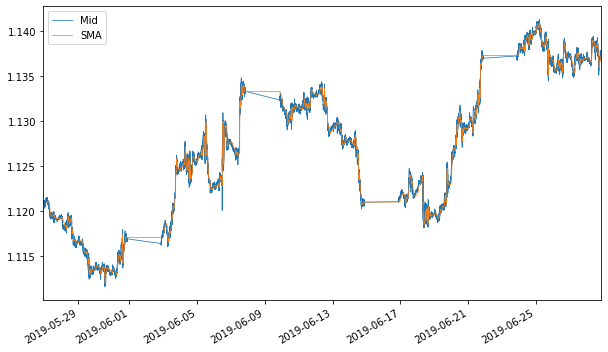

In [6]:
sub['Mid'] = sub.mean(axis=1)  
sub['SMA'] = sub['Mid'].rolling(10000).mean() 
sub[['Mid', 'SMA']].plot(figsize=(10, 6), lw=0.75);

In [91]:
data = api.get_candles('EUR/USD', period='m5',
                        start='2019-06-01 00:00:00',
                        stop='2019-06-30 00:00:00')  

In [92]:
data['midclose']=(data['askclose']+data['bidclose'])/2

In [93]:
data['pct']=(data['askclose']-data['bidclose'])/data['midclose']    #commission fee for spread

In [94]:
data.head()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,midclose,pct
date,,,,,,,,,,,
2019-06-02 19:00:00,1.11680,1.11647,1.11648,1.11647,1.11704,1.11701,1.11703,1.11701,4,1.116740,0.000484
2019-06-02 19:05:00,1.11647,1.11647,1.11647,1.11647,1.11701,1.11690,1.11690,1.11690,1,1.116685,0.000385
2019-06-02 19:10:00,1.11647,1.11650,1.11650,1.11635,1.11690,1.11697,1.11699,1.11690,3,1.116735,0.000421
2019-06-02 19:20:00,1.11650,1.11608,1.11644,1.11600,1.11697,1.11650,1.11689,1.11647,14,1.116290,0.000376
2019-06-02 19:25:00,1.11608,1.11600,1.11608,1.11594,1.11650,1.11649,1.11650,1.11613,15,1.116245,0.000439


In [109]:
data['returns'] = np.log(data['midclose'] / data['midclose'].shift(1))
data['returns_2'] = np.log(data['midclose'] / data['midclose'].shift(1))
data.dropna(inplace=True)                                                                  

In [110]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['returns'].shift(lag)  
    cols.append(col)
data.dropna(inplace=True)
data[cols] = np.where(data[cols] > 0, 1, 0)  
data['direction'] = np.where(data['returns_2'] > 0, 1, -1) 

In [111]:
signal=data[cols + ['direction','returns']]

In [45]:
# linear model
from sklearn import linear_model, metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
models = {
    #'log_reg': linear_model.LogisticRegression(),
    #'gauss_nb': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state = 0),
    'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),\
                                             n_estimators = 10,random_state = 0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 0),
    'SVC': SVC(probability=True,random_state = 0)

}

In [46]:
model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                               'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},
    'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                             'min_samples_split':[2],'criterion':['entropy'],\
                             'min_samples_leaf':[3]},
    'AdaBoostClassifier': {"base_estimator__criterion" : ["entropy"],\
                           "base_estimator__max_depth": [None],\
                           "base_estimator__min_samples_leaf" : [3],\
                           "base_estimator__min_samples_split" : [2],\
                           "base_estimator__max_features" : [None]},
    'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                                   'min_samples_split':[2],'min_samples_leaf':[3],\
                                   'learning_rate':[0.1],'subsample':[1.0]},
    'SVC': [{'kernel':['rbf'],'gamma':[1e-1],'C':[1]},\
            {'kernel':['linear'],'C':[1,10]}]
}

In [121]:
class Model_Selection:
    
    def __init__(self,models,model_grid_params,signal,test):
        
        self.models = models
        self.model_grid = model_grid_params
        self.data = signal
        self.keys = models.keys()
        self.best_score = {}
        self.grid = {}
        self.predict_values = {}
        self.cv_acc = {}
        self.acc = {}
        self.fscore = {}
        self.true_values = {}
        self.acc_day = {}
        self.summary = []
        self.test=test
        
    def Grid_fit(self,X_train,y_train,cv = 5,scoring = 'accuracy'):
        
        for key in self.keys:
            #print ("Running GridSearchCV for %s." %(key))
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv = cv, scoring = scoring)
            Grid.fit(X_train,y_train) 
            self.grid[key] = Grid
            print (Grid.best_params_)
            print ('CV best Score = %s'%(Grid.best_score_))
            if key not in self.cv_acc:
                self.cv_acc[key]=[]
            self.cv_acc[key].append(Grid.best_score_)  
    
    def model_fit(self,X_train, y_train, X_test, y_test):
        
        for key in self.keys:

            model = self.models[key]

            model.set_params(**self.grid[key].best_params_)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            if key not in self.predict_values:
                self.predict_values[key]=[]
            self.predict_values[key].append(predictions.tolist())
            if key not in self.true_values:
                self.true_values[key]=[]
            self.true_values[key].append(y_test.tolist())
            
            acc = metrics.accuracy_score(y_test,predictions)
            f_score = metrics.f1_score(y_test,predictions)
            print ('Accuracy = %s'%(acc), key)
            if key not in self.acc:
                self.acc[key]=[]
            self.acc[key].append(acc)
            if key not in self.fscore:
                self.fscore[key]=[]
            self.fscore[key].append(f_score)
            
    def plot_return(self):
        for key in self.keys:
            self.test['pos_' + key] = self.predict_values[key]
        sel = []
        pct=0.001
        for key in self.keys():
            col1 = 'strat_' + model 
            self.test[col1] = test['pos_' + key] * self.test['returns']
            col2 = 'strat_tc'+model
            self.test[col2] = np.where(self.test['pos_' + model].diff() != 0,
                               self.test[col1] - pct,  
                               self.test[col1])
            sel.append(col2)
        sel.insert(0, 'returns')
        print(self.test[sel].sum().apply(np.exp) ) 
        from pylab import mpl, plt
        %matplotlib inline
        self.test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
            
    def pipline(self):
        split= int(len(self.data.index)*0.9)
        X_train = self.data.iloc[:split,[0,1,2,3,4]]
        y_train = self.data.iloc[:split,-2]

        # Test data
        X_test = self.data.iloc[split:,[0,1,2,3,4]]
        y_test = self.data.iloc[split:,-2]
                
                
        self.Grid_fit(X_train, y_train, cv = 5, scoring = 'accuracy')
        self.model_fit(X_train, y_train,X_test,y_test)



          
    def print_(self):
        return self.fscore, self.true_values, self.acc, self.predict_values

In [104]:
split= int(len(signal.index)*0.9)

test=signal.iloc[split:]

In [122]:
pip = Model_Selection(models,model_grid_params,signal,test)

In [123]:
import time
start = time.time()
pip.pipline()
end = time.time()
print ('Total Time = %s'%(end-start))

{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV best Score = 0.5002858776443682
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV best Score = 0.5004764627406136
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2}
CV best Score = 0.5010482180293501
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}
CV best Score = 0.5004764627406136
{'C': 1, 'kernel': 'linear'}
CV best Score = 0.5128644939965694
Accuracy = 0.5136986301369864 RandomForestClassifier
Accuracy = 0.5222602739726028 ExtraTreesClassifier
Accuracy = 0.5222602739726028 AdaBoostClassifier
Accuracy = 0.5222602739726028 GradientBoo

In [124]:
fscore, true_values, acc, predict_values=pip.print_()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

returns                               1.000277
strat_tcRandomForestClassifier        0.750707
strat_tcExtraTreesClassifier          0.733958
strat_tcAdaBoostClassifier            0.733958
strat_tcGradientBoostingClassifier    0.733958
strat_tcSVC                           0.730728
dtype: float64


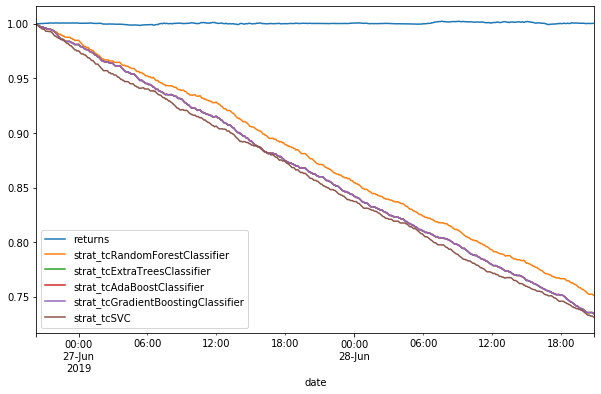

In [137]:
for key in models.keys():
    test['pos_' + key] = predict_values[key][0]
global sel 
sel = []
pct=0.001
for key in models.keys():
    col1 = 'strat_' + key 
    test[col1] = test['pos_' + key] * test['returns']
    col2 = 'strat_tc'+key
    test[col2] = np.where(test['pos_' + key].diff() != 0,
                               test[col1] - pct,  
                               test[col1])
    sel.append(col2)
sel.insert(0, 'returns')
print(test[sel].sum().apply(np.exp) ) 
from pylab import mpl, plt
%matplotlib inline
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));